In [11]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

import os
import random

In [12]:
import sklearn
import tensorflow 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
from tcn import TCN  

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, TimeSeriesSplit
from keras_tuner.tuners import BayesianOptimization
from keras.callbacks import EarlyStopping

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [14]:
import xgboost
from xgboost import XGBRegressor


In [15]:
os.environ['PYTHONHASHSEED'] = '42'  

random.seed(42)          
np.random.seed(42)       
tensorflow.random.set_seed(42)  

In [16]:
# load the data into dataframe
df=pd.read_csv('feature_engineered_data.csv')
print(df.head())

   current_value  lights         T1       RH_1         T2       RH_2  \
0          430.0      30  20.133333  48.000000  19.566667  44.400000   
1          250.0      30  20.260000  52.726667  19.730000  45.100000   
2          100.0      10  20.426667  55.893333  19.856667  45.833333   
3          100.0      10  20.566667  53.893333  20.033333  46.756667   
4           90.0      10  20.730000  52.660000  20.166667  47.223333   

          T3       RH_3         T4       RH_4  ...  is_weekend    nsm  lag_1  \
0  19.890000  44.900000  19.000000  46.363333  ...           0  68400  576.6   
1  19.890000  45.493333  19.000000  47.223333  ...           0  69000  430.0   
2  20.033333  47.526667  19.000000  48.696667  ...           0  69600  250.0   
3  20.100000  48.466667  19.000000  48.490000  ...           0  70200  100.0   
4  20.200000  48.530000  18.926667  48.156667  ...           0  70800  100.0   

   lag_2  lag_6  lag_12  hour_sin  hour_cos  rolling_mean_12  rolling_std_12  
0  230.

In [17]:
import pickle

forecast_horizon=[10,20,30,40,50,60]
selected_features={}

for mins in forecast_horizon:
       with open(f'selected_features_{mins}min.pkl', 'rb') as f:
        selected_features[f'selected_feature{mins}'] = pickle.load(f)

print(selected_features)

    

{'selected_feature10': ['current_value', 'RH_5', 'T6', 'T8', 'RH_8', 'Press_mm_hg', 'nsm', 'lag_1', 'rolling_mean_12', 'rolling_std_12'], 'selected_feature20': ['current_value', 'RH_3', 'T4', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'nsm', 'rolling_mean_12', 'rolling_std_12'], 'selected_feature30': ['current_value', 'RH_2', 'T4', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'nsm', 'rolling_mean_12', 'rolling_std_12'], 'selected_feature40': ['current_value', 'T3', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'RH_out', 'nsm', 'rolling_mean_12', 'rolling_std_12'], 'selected_feature50': ['current_value', 'T3', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'Tdewpoint', 'nsm', 'rolling_mean_12', 'rolling_std_12'], 'selected_feature60': ['current_value', 'T3', 'RH_5', 'RH_8', 'T_out', 'Press_mm_hg', 'nsm', 'hour_cos', 'rolling_mean_12', 'rolling_std_12']}


In [18]:

def create_sequences(data, target_column, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

In [19]:


def model_implementation(model_name, model, df, selected_features, model_type='xgb'):
    forecast_horizon = [10, 20, 30, 40, 50, 60]
    results = {}

    for i in forecast_horizon:
        df_copy = df.copy()
        step = i // 10
        df_copy['target'] = df_copy['current_value'].shift(-step)
        df_copy = df_copy.dropna().reset_index(drop=True)

        selected = selected_features[f'selected_feature{i}']
        df_copy = df_copy[selected + ['target']]

        if model_type == 'xgb':

            X = df_copy.drop(columns=['target'])
            y = df_copy['target']

            train_size = int(0.8 * len(df_copy))
            X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
            y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
            scaler_X = MinMaxScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_test_scaled = scaler_X.transform(X_test)

            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        else:
            # Scale full train/test including target
            train_size = int(0.8 * len(df_copy))
            df_train = df_copy.iloc[:train_size]
            df_test = df_copy.iloc[train_size:]

            scaler = MinMaxScaler()
            df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_copy.columns)
            df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_copy.columns)

            window_size = 24
            X_train_seq, y_train_seq = create_sequences(df_train_scaled, 'target', window_size)
            X_test_seq, y_test_seq = create_sequences(df_test_scaled, 'target', window_size)

            target_scaler = MinMaxScaler()
            target_scaler.fit(df_copy[['target']])

            if model_type == 'lstm':
                dl_model = Sequential()
                dl_model.add(LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
                dl_model.add(Dense(1))
            elif model_type == 'tcn-lstm':
                dl_model = Sequential([
                    TCN(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
                    LSTM(50),
                    Dense(1)
                ])
            else:
                raise ValueError("Invalid model_type. Choose from 'xgb', 'gru', 'tcn-lstm'.")

            dl_model.compile(optimizer='adam', loss='mse')
            dl_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.1, verbose=0,shuffle=False)
            y_pred = dl_model.predict(X_test_seq)

            y_test_actual = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))
            y_pred_actual = target_scaler.inverse_transform(y_pred)

            r2 = r2_score(y_test_actual, y_pred_actual)
            mae = mean_absolute_error(y_test_actual, y_pred_actual)
            rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

        results[f'{i}_min'] = {
            'R2': round(r2, 4),
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4)
        }

        # Print
        print(f"🔹 {model_name} | Step {i} min")
        print(f"R² Score: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print("-" * 40)

    return results


In [20]:
from xgboost import XGBRegressor

# For XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
results_xgb = model_implementation("XGBoost", xgb_model, df, selected_features, model_type='xgb')

# For GRU
results_gru = model_implementation("LSTM", None, df, selected_features, model_type='lstm')

# For TCN-LSTM
results_tcn_lstm = model_implementation("TCN-LSTM", None, df, selected_features, model_type='tcn-lstm')


🔹 XGBoost | Step 10 min
R² Score: 0.5764
MAE: 27.0544
RMSE: 56.5780
----------------------------------------
🔹 XGBoost | Step 20 min
R² Score: 0.0839
MAE: 53.9006
RMSE: 83.1990
----------------------------------------
🔹 XGBoost | Step 30 min
R² Score: -0.3040
MAE: 64.1601
RMSE: 99.1915
----------------------------------------
🔹 XGBoost | Step 40 min
R² Score: -0.1155
MAE: 60.3815
RMSE: 91.7435
----------------------------------------
🔹 XGBoost | Step 50 min
R² Score: -0.1325
MAE: 62.0251
RMSE: 92.4420
----------------------------------------
🔹 XGBoost | Step 60 min
R² Score: 0.1073
MAE: 49.9063
RMSE: 82.0737
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔹 LSTM | Step 10 min
R² Score: 0.5709
MAE: 26.7670
RMSE: 55.6030
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔹 LSTM | Step 20 min
R² Score: 0.5599
MAE: 29.2935
RMSE: 56.3102
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔹 LSTM | Step 30 min
R² Score: 0.5675
MAE: 28.2822
RMSE: 55.7765
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔹 LSTM | Step 40 min
R² Score: 0.5575
MAE: 27.8004
RMSE: 56.4125
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔹 LSTM | Step 50 min
R² Score: 0.5767
MAE: 27.1861
RMSE: 55.1760
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔹 LSTM | Step 60 min
R² Score: 0.5833
MAE: 27.6044
RMSE: 54.7460
----------------------------------------



c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
🔹 TCN-LSTM | Step 10 min
R² Score: 0.5391
MAE: 26.9988
RMSE: 57.6267
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
🔹 TCN-LSTM | Step 20 min
R² Score: 0.5227
MAE: 27.4880
RMSE: 58.6400
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
🔹 TCN-LSTM | Step 30 min
R² Score: 0.5486
MAE: 26.9822
RMSE: 56.9798
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
🔹 TCN-LSTM | Step 40 min
R² Score: 0.4993
MAE: 27.7904
RMSE: 60.0082
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
🔹 TCN-LSTM | Step 50 min
R² Score: 0.4786
MAE: 27.9225
RMSE: 61.2363
----------------------------------------


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
🔹 TCN-LSTM | Step 60 min
R² Score: 0.5358
MAE: 26.3019
RMSE: 57.7800
----------------------------------------


<Figure size 800x400 with 0 Axes>

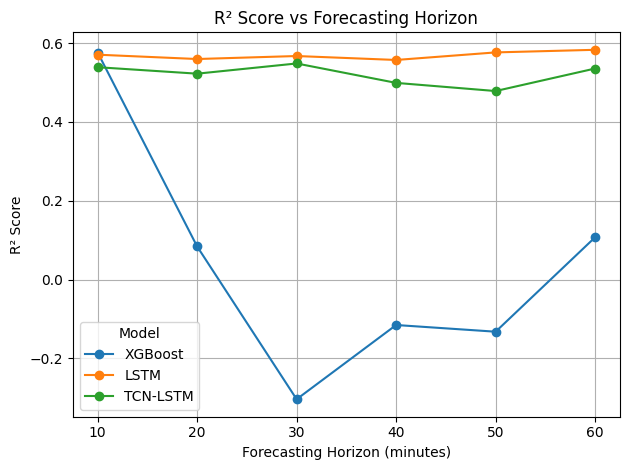

<Figure size 800x400 with 0 Axes>

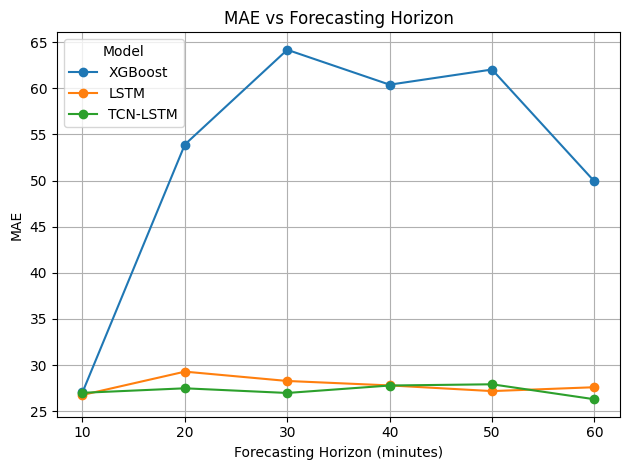

<Figure size 800x400 with 0 Axes>

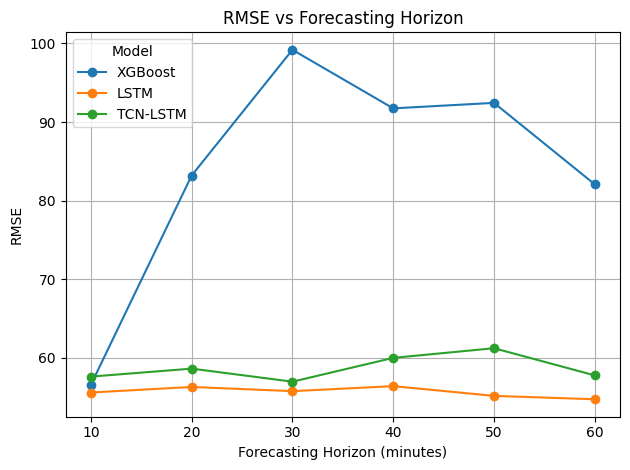

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: your collected results from the function calls
# You should already have these if you called:
# results_xgb, results_gru, results_tcn_lstm

all_results = {
    "XGBoost": results_xgb,
    "LSTM": results_gru,
    "TCN-LSTM": results_tcn_lstm
}

# Initialize DataFrames
r2_df = pd.DataFrame()
mae_df = pd.DataFrame()
rmse_df = pd.DataFrame()

# Fill in the metric DataFrames
for model_name, res in all_results.items():
    r2_series = pd.Series({int(k.split("_")[0]): v["R2"] for k, v in res.items()})
    mae_series = pd.Series({int(k.split("_")[0]): v["MAE"] for k, v in res.items()})
    rmse_series = pd.Series({int(k.split("_")[0]): v["RMSE"] for k, v in res.items()})
    
    r2_df[model_name] = r2_series
    mae_df[model_name] = mae_series
    rmse_df[model_name] = rmse_series

# Sort index to ensure correct order
r2_df.sort_index(inplace=True)
mae_df.sort_index(inplace=True)
rmse_df.sort_index(inplace=True)

# Plot R2
plt.figure(figsize=(8, 4))
r2_df.plot(marker='o')
plt.title("R² Score vs Forecasting Horizon")
plt.xlabel("Forecasting Horizon (minutes)")
plt.ylabel("R² Score")
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(8, 4))
mae_df.plot(marker='o')
plt.title("MAE vs Forecasting Horizon")
plt.xlabel("Forecasting Horizon (minutes)")
plt.ylabel("MAE")
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 4))
rmse_df.plot(marker='o')
plt.title("RMSE vs Forecasting Horizon")
plt.xlabel("Forecasting Horizon (minutes)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


In [22]:
import openpyxl

In [23]:
def hyperparameter_tuning_xgboost(df,selected_features):

    forecast_horizon=[10,20,30,40,50,60]
    results = {}

    for i in forecast_horizon:
        print(f"Model Name: XgBoost | {i}mins forecasting")

        df_copy = df.copy()
        step = i // 10
        df_copy['target'] = df_copy['current_value'].shift(-step)
        df_copy = df_copy.dropna().reset_index(drop=True)

        selected = selected_features[f'selected_feature{i}']
        df_copy = df_copy[selected + ['target']]

        X = df_copy.drop(columns=['target'])
        y = df_copy['target']

        train_size = int(0.8 * len(df_copy))
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

        scaler_X = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

        xgb_params = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1]
        }

        tscv = TimeSeriesSplit(n_splits=5)

        grid_xgb = GridSearchCV(xgb, xgb_params, cv=tscv, scoring='r2', n_jobs=-1)
        grid_xgb.fit(X_train_scaled, y_train)

        print("Best XGB Parameters:", grid_xgb.best_params_)
        print("Best XGB CV R²:", grid_xgb.best_score_)

        y_pred = grid_xgb.predict(X_test_scaled)


        r2 = r2_score(y_test, y_pred)
        mae  = mean_absolute_error(y_test, y_pred)
        rmse  = np.sqrt(mean_squared_error(y_test, y_pred))

        results[f'{i}_min'] = {
            'R2': round(r2, 4),
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4)
        }

        # Print evaluation metrics
        print(f"Model Name: XgBoost | {i}mins forecasting")
        print("R² Score:", r2)
        print("MAE:", mae)
        print("RMSE:", rmse)
        print('------'*20)

    return results

results_xgb_ht=hyperparameter_tuning_xgboost(df,selected_features)


Model Name: XgBoost | 10mins forecasting
Best XGB Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best XGB CV R²: 0.6117955431105627
Model Name: XgBoost | 10mins forecasting
R² Score: 0.5899071761082513
MAE: 25.75774524819261
RMSE: 55.666650706342665
------------------------------------------------------------------------------------------------------------------------
Model Name: XgBoost | 20mins forecasting
Best XGB Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGB CV R²: 0.35158850719198015
Model Name: XgBoost | 20mins forecasting
R² Score: 0.3368001410864945
MAE: 36.20585661971523
RMSE: 70.79070209075611
------------------------------------------------------------------------------------------------------------------------
Model Name: XgBoost | 30mins forecasting
Best XGB Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3

In [24]:
from keras.layers import Dropout

def hyperparameter_tuning_tcn_lstm(df,selected_features):
    forecast_horizon=[10,20,30,40,50,60]
    results={}

    for i in forecast_horizon:

        print(f"Model Name: TCN-LSTM | {i}mins forecasting")

        df_copy = df.copy()
        step = i // 10
        df_copy['target'] = df_copy['current_value'].shift(-step)
        df_copy = df_copy.dropna().reset_index(drop=True)

        selected = selected_features[f'selected_feature{i}']
        df_copy = df_copy[selected + ['target']]

        train_size = int(0.8 * len(df))

        df_train = df_copy.iloc[:train_size]
        df_test = df_copy.iloc[train_size:]

        scaler = MinMaxScaler()
        df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_copy.columns)
        df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_copy.columns)

        window_size = 24
        X_train, y_train = create_sequences(df_train_scaled, 'target', window_size)
        X_test, y_test = create_sequences(df_test_scaled, 'target', window_size)

        target_scaler = MinMaxScaler()
        target_scaler.fit(df_copy[['target']])

        val_size = int(len(X_train) * 0.125)

        X_train_final = X_train[:-val_size]
        y_train_final = y_train[:-val_size]

        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]

        def build_tcn_lstm_model(hp):
            model = Sequential()

            # Get dilation depth (e.g., 3 → [1, 2, 4], 4 → [1, 2, 4, 8])
            dilation_depth = hp.Int('dilation_depth', 2, 4)  # depth of dilations
            dilations = [2**i for i in range(dilation_depth)]

            model.add(TCN(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                nb_filters=hp.Int('nb_filters', 32, 128, step=32),
                kernel_size=hp.Choice('kernel_size', [2, 3, 5]),
                dilations=dilations,
                return_sequences=True,
                dropout_rate=hp.Float('tcn_dropout', 0.1, 0.5, step=0.1)
            ))

            model.add(LSTM(units=hp.Int('lstm_units', 32, 128, step=32)))

            model.add(Dense(1))

            model.compile(
                optimizer=tensorflow.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                loss='mse',
                metrics=['mae']
            )

            return model
        
        tuner = BayesianOptimization(
            build_tcn_lstm_model,
            objective='val_mae',
            max_trials=10,
            directory='6-step',
            project_name=f'bayes_tcn_lstm{i}'
            )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        tuner.search(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1,
            shuffle=False
        )

        best_model = tuner.get_best_models(num_models=1)[0]
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

        print("Best hyperparameters:")
        for param in best_hp.values:
            print(f"{param}: {best_hp.get(param)}")

        y_pred_tcn_lstm = best_model.predict(X_test)

        y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_actual = target_scaler.inverse_transform(y_pred_tcn_lstm)

        r2 = r2_score(y_test_actual, y_pred_actual)
        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

        results[f'{i}_min'] = {
            'R2': round(r2, 4),
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4)
        }

        print(f" R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        print('------'*20)
    print(results)
    return results

results_tcn_lstm_ht= hyperparameter_tuning_tcn_lstm(df,selected_features)   

        


Trial 10 Complete [00h 01m 40s]
val_mae: 0.06600198149681091

Best val_mae So Far: 0.04518325626850128
Total elapsed time: 00h 11m 20s
Best hyperparameters:
dilation_depth: 2
nb_filters: 32
kernel_size: 5
tcn_dropout: 0.4
lstm_units: 128
learning_rate: 0.001
  1/123 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step

c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
 R²: 0.5328, MAE: 26.58, RMSE: 57.86
------------------------------------------------------------------------------------------------------------------------
{'10_min': {'R2': 0.5651, 'MAE': 25.4177, 'RMSE': np.float64(55.9253)}, '20_min': {'R2': 0.5471, 'MAE': 25.0871, 'RMSE': np.float64(57.013)}, '30_min': {'R2': 0.5542, 'MAE': 25.1485, 'RMSE': np.float64(56.5483)}, '40_min': {'R2': 0.5419, 'MAE': 25.9194, 'RMSE': np.float64(57.2941)}, '50_min': {'R2': 0.5266, 'MAE': 25.6154, 'RMSE': np.float64(58.2365)}, '60_min': {'R2': 0.5328, 'MAE': 26.5779, 'RMSE': np.float64(57.8618)}}


In [25]:
def hyperparameter_tuning_lstm(df,selected_features):
    forecast_horizon=[10,20,30,40,50,60]
    results={}

    for i in forecast_horizon:

        print(f"Model Name: LSTM | {i}mins forecasting")

        df_copy = df.copy()
        step = i // 10
        df_copy['target'] = df_copy['current_value'].shift(-step)
        df_copy = df_copy.dropna().reset_index(drop=True)

        selected = selected_features[f'selected_feature{i}']
        df_copy = df_copy[selected + ['target']]

        train_size = int(0.8 * len(df))

        df_train = df_copy.iloc[:train_size]
        df_test = df_copy.iloc[train_size:]

        scaler = MinMaxScaler()
        df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_copy.columns)
        df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_copy.columns)

        window_size = 24
        X_train, y_train = create_sequences(df_train_scaled, 'target', window_size)
        X_test, y_test = create_sequences(df_test_scaled, 'target', window_size)

        target_scaler = MinMaxScaler()
        target_scaler.fit(df_copy[['target']])

        val_size = int(len(X_train) * 0.125)

        X_train_final = X_train[:-val_size]
        y_train_final = y_train[:-val_size]

        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]

        def build_gru_model(hp):
            model = Sequential()
            model.add(LSTM(
                units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
                return_sequences=False
            ))
            
            model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
            model.add(Dense(1))

            model.compile(
                loss='mse',
                optimizer=hp.Choice('optimizer', ['adam']),
                metrics=['mae']
            )
            return model
        
        tuner = BayesianOptimization(
            build_gru_model,
            objective='val_mae',
            max_trials=10,
            directory='6-step',
            project_name=f'bayes_gru{i}'
            )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        tuner.search(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1,
            shuffle=False
        )

        best_model = tuner.get_best_models(num_models=1)[0]
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

        print("Best hyperparameters:")
        for param in best_hp.values:
            print(f"{param}: {best_hp.get(param)}")

        history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=32,
                        callbacks=[early_stop],shuffle=False)

        y_pred_tcn_lstm = best_model.predict(X_test)

        y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
        y_pred_actual = target_scaler.inverse_transform(y_pred_tcn_lstm)

        r2 = r2_score(y_test_actual, y_pred_actual)
        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

        results[f'{i}_min'] = {
            'R2': round(r2, 4),
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4)
        }

        print(f" R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        print('------'*20)

    print(results)
    return results

results_lstm_ht= hyperparameter_tuning_lstm(df,selected_features)         

Trial 10 Complete [00h 00m 28s]
val_mae: 0.04542873054742813

Best val_mae So Far: 0.043755676597356796
Total elapsed time: 00h 04m 37s
Best hyperparameters:
units_1: 96
dropout_1: 0.5
optimizer: adam
Epoch 1/20


c:\Users\Rukhsana\anaconda3\envs\project\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0149 - mae: 0.0660 - val_loss: 0.0099 - val_mae: 0.0543
Epoch 2/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0147 - mae: 0.0657 - val_loss: 0.0096 - val_mae: 0.0495
Epoch 3/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0148 - mae: 0.0654 - val_loss: 0.0095 - val_mae: 0.0472
Epoch 4/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0144 - mae: 0.0637 - val_loss: 0.0095 - val_mae: 0.0479
Epoch 5/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0142 - mae: 0.0636 - val_loss: 0.0094 - val_mae: 0.0474
Epoch 6/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0141 - mae: 0.0633 - val_loss: 0.0093 - val_mae: 0.0473
Epoch 7/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0143 - mae: 0.0638 - val_loss: 0.0092 - val_mae: 0.0448
Epoch 8/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0141 - mae: 0.0631 - val_loss: 0.0091 - val_mae: 0.0448
Epoch 9/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0140 

<Figure size 800x400 with 0 Axes>

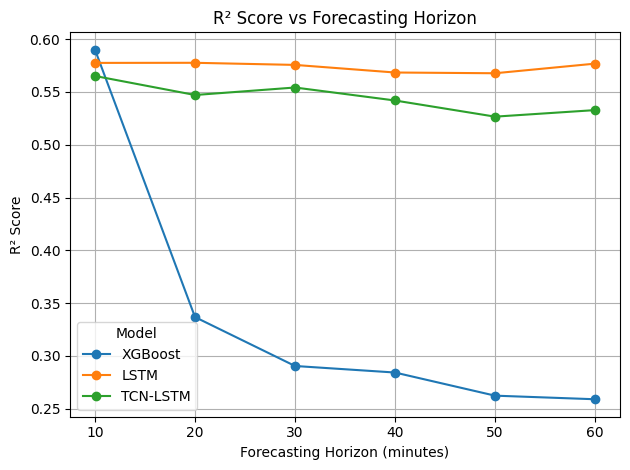

<Figure size 800x400 with 0 Axes>

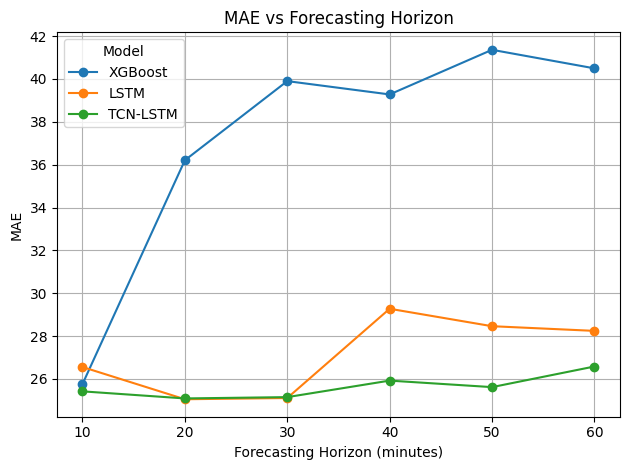

<Figure size 800x400 with 0 Axes>

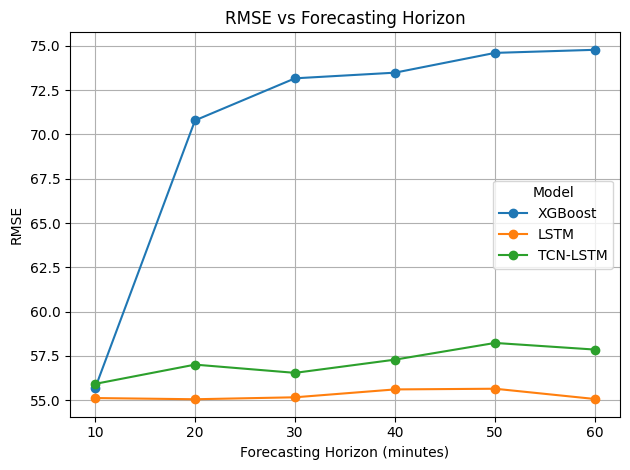

In [26]:
all_results_ht = {
    "XGBoost": results_xgb_ht,
    "LSTM": results_lstm_ht,
    "TCN-LSTM": results_tcn_lstm_ht
}

# Initialize DataFrames
r2_df = pd.DataFrame()
mae_df = pd.DataFrame()
rmse_df = pd.DataFrame()

# Fill in the metric DataFrames
for model_name, res in all_results_ht.items():
    r2_series = pd.Series({int(k.split("_")[0]): v["R2"] for k, v in res.items()})
    mae_series = pd.Series({int(k.split("_")[0]): v["MAE"] for k, v in res.items()})
    rmse_series = pd.Series({int(k.split("_")[0]): v["RMSE"] for k, v in res.items()})
    
    r2_df[model_name] = r2_series
    mae_df[model_name] = mae_series
    rmse_df[model_name] = rmse_series

# Sort index to ensure correct order
r2_df.sort_index(inplace=True)
mae_df.sort_index(inplace=True)
rmse_df.sort_index(inplace=True)

# Plot R2
plt.figure(figsize=(8, 4))
r2_df.plot(marker='o')
plt.title("R² Score vs Forecasting Horizon")
plt.xlabel("Forecasting Horizon (minutes)")
plt.ylabel("R² Score")
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(8, 4))
mae_df.plot(marker='o')
plt.title("MAE vs Forecasting Horizon")
plt.xlabel("Forecasting Horizon (minutes)")
plt.ylabel("MAE")
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 4))
rmse_df.plot(marker='o')
plt.title("RMSE vs Forecasting Horizon")
plt.xlabel("Forecasting Horizon (minutes)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [28]:
with pd.ExcelWriter("forecasting_metrics.xlsx") as writer:
    r2_df.to_excel(writer, sheet_name='R2_Score')
    mae_df.to_excel(writer, sheet_name='MAE')
    rmse_df.to_excel(writer, sheet_name='RMSE')

print("✅ Metrics saved to 'forecasting_metrics.xlsx'")

✅ Metrics saved to 'forecasting_metrics.xlsx'
